# Planar data classification with one hidden layer


## Table of Contents
- [1 - Packages](#1)
- [2 - Loading the Dataset](#2)
    - [Step 1](#ex-1)
- [3 - Simple Logistic Regression](#3)
- [4 - Neural Network model](#4)
    - [4.1 - Defining the neural network structure](#4-1)
        - [Step 2 - layer_sizes](#ex-2)
    - [4.2 - Initializing the model's parameters](#4-2)
        - [Step 3 - initialize_parameters](#ex-3)
    - [4.3 - The Loop](#4-3)
        - [Step 4 - forward_propagation](#ex-4)
    - [4.4 - Computing the Cost](#4-4)
        - [Step 5 - compute_cost](#ex-5)
    - [4.5 - Implementing Backpropagation](#4-5)
        - [Step 6 - backward_propagation](#ex-6)
    - [4.6 - Updating Parameters](#4-6)
        - [Step 7 - update_parameters](#ex-7)
    - [4.7 - Integration](#4-7)
        - [Step 8 - nn_model](#ex-8)
- [5 - Testing the Model](#5)
    - [5.1 - Predict](#5-1)
        - [Step 9 - predict](#ex-9)
    - [5.2 - Test the Model on the Planar Dataset](#5-2)
- [6 - Tuning hidden layer size](#6)
- [7- Performance on other datasets](#7)

<a name='1'></a>
# 1 - Packages

First import all the packages that you will need during this assignment.

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- planar_utils provide various useful functions used in this assignment

In [5]:
# Package imports
import numpy as np
import copy
import matplotlib.pyplot as plt
from testCases_v2 import *
from public_tests import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
# 2 - Loading the Dataset



In [6]:
X, Y = load_planar_dataset()

The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Our goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

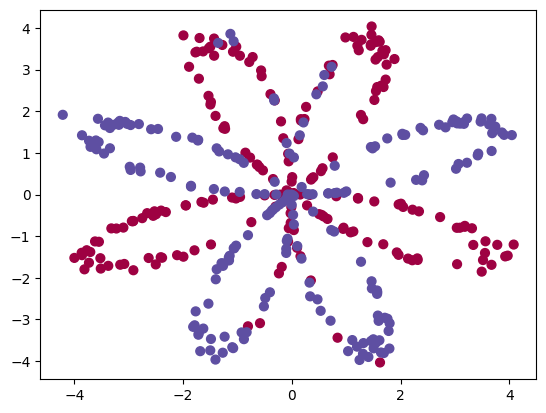

In [7]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

We have:
    - a numpy-array (matrix) X that contains the features (x1, x2)
    - a numpy-array (vector) Y that contains the labels (red:0, blue:1).


<a name='ex-1'></a>
### Step 1

In [8]:
shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


<a name='3'></a>
## 3 - Simple Logistic Regression

Before building a full neural network, let's check how logistic regression performs on this problem.

In [9]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression: 47 % 


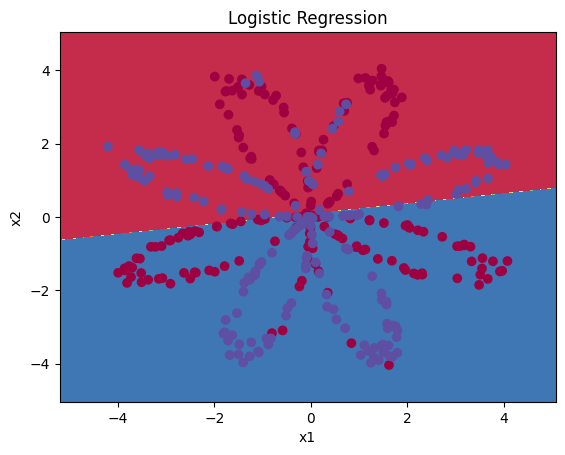

In [10]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ')

**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well.

<a name='4'></a>
## 4 - Neural Network model

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, we can also compute the cost $J$ as follows:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$


<a name='4-1'></a>
### 4.1 - Defining the neural network structure ####

<a name='ex-2'></a>
### Step 2 - layer_sizes


In [11]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)

    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]

    return (n_x, n_h, n_y)

<a name='4-2'></a>
### 4.2 - Initializing the model's parameters ####

<a name='ex-3'></a>
### Step 3 -  initialize_parameters

In [12]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y,1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

<a name='4-3'></a>
### 4.3 - The Loop

<a name='ex-4'></a>
### Step 4 - forward_propagation

Equations:

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$


In [13]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)

    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

<a name='4-4'></a>
### 4.4 - Computing the Cost

Cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

<a name='ex-5'></a>
### Step 5 - compute_cost


In [14]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)

    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)

    """

    m = Y.shape[1]

    logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y), np.log(1-A2))
    cost = -1/m * np.sum(logprobs)

    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect.

    return cost

<a name='4-5'></a>
### 4.5 - Implement Backpropagation

Using the cache computed during forward propagation, we can now implement backward propagation.

<a name='ex-6'></a>
### Step 6 -  backward_propagation

Equations:


$$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$$

$$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $$

$$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$$

$$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $$

$$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $$

$$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$$


To compute dZ1 we need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So we can compute
    $g^{[1]'}(Z^{[1]})$ using (1 - np.power(A1, 2))

In [15]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.

    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]

    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]

    # Backward propagation: calculate dW1, db1, dW2, db2.
    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

<a name='4-6'></a>
### 4.6 - Updating Parameters

<a name='ex-7'></a>
### Step 7 - update_parameters

Let's implement the update rule using gradient descent.

**General gradient descent rule**: $\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate


In [16]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients

    Returns:
    parameters -- python dictionary containing your updated parameters
    """

    # Retrieve a copy of each parameter from the dictionary "parameters". Use copy.deepcopy(...) for W1 and W2
    W1 = copy.deepcopy(parameters["W1"])
    b1 = parameters["b1"]
    W2 = copy.deepcopy(parameters["W2"])
    b2 = parameters["b2"]


    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    # Update rule for each parameter
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

<a name='4-7'></a>
### 4.7 - Integration

<a name='ex-8'></a>
### Step 8 - nn_model

We will now build out neural network model in nn_model().

In [17]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [18]:
nn_model_test(nn_model)

Cost after iteration 0: 0.693086
Cost after iteration 1000: 0.000220
Cost after iteration 2000: 0.000108
Cost after iteration 3000: 0.000072
Cost after iteration 4000: 0.000054
Cost after iteration 5000: 0.000043
Cost after iteration 6000: 0.000036
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000027
Cost after iteration 9000: 0.000024
W1 = [[ 0.71392202  1.31281102]
 [-0.76411243 -1.41967065]
 [-0.75040545 -1.38857337]
 [ 0.56495575  1.04857776]]
b1 = [[-0.0073536 ]
 [ 0.01534663]
 [ 0.01262938]
 [ 0.00218135]]
W2 = [[ 2.82545815 -3.3063945  -3.16116615  1.8549574 ]]
b2 = [[0.00393452]]
All tests passed!


<a name='5'></a>
## 5 - Testing the Model

<a name='5-1'></a>
### 5.1 - Predict

<a name='ex-9'></a>
### Step 9 - predict

In [19]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)

    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)

    return predictions

<a name='5-2'></a>
### 5.2 - Testing the Model on the Planar Dataset

Let's run the model and see how it performs on a planar dataset.

Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220648
Cost after iteration 8000: 0.219405
Cost after iteration 9000: 0.218484


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

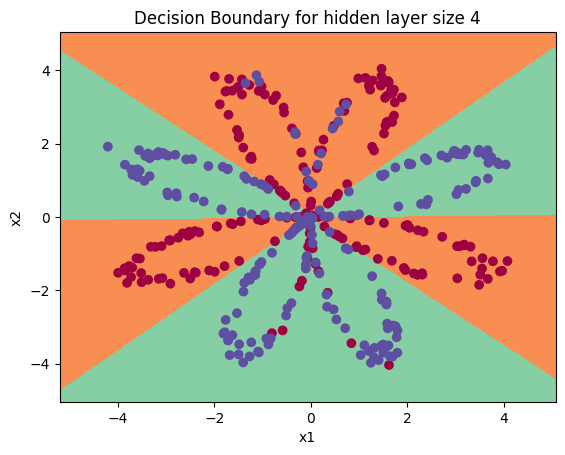

In [20]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [21]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 90%


Accuracy is really high compared to Logistic Regression. The model has learned the patterns of the flower's petals! Unlike logistic regression, neural networks are able to learn even highly non-linear decision boundaries.

<a name='6'></a>
## 6 - Tuning hidden layer size

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %


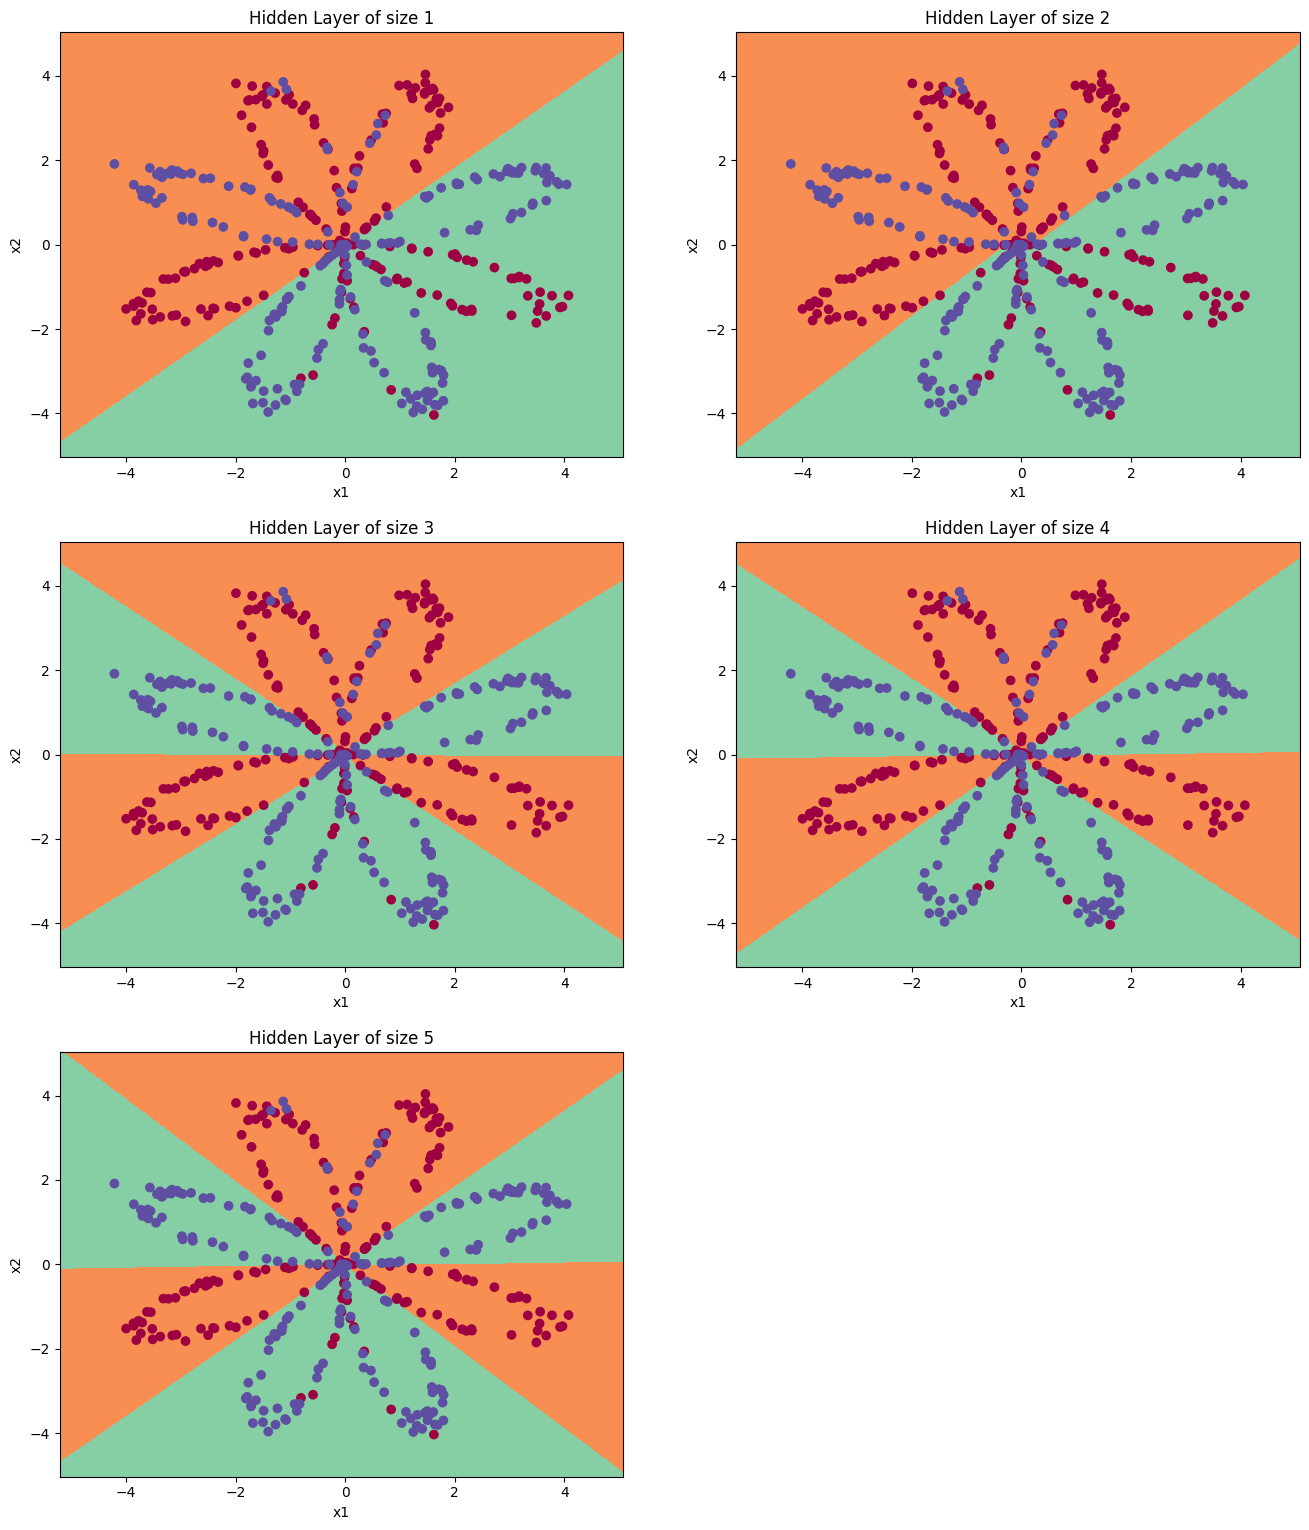

In [22]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data.
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticeable overfitting.
- Later, you'll become familiar with regularization, which lets you use very large models (such as n_h = 50) without much overfitting.

<a name='7'></a>
## 7- Performance on other datasets

Cost after iteration 0: 0.693147
Cost after iteration 1000: 0.488997
Cost after iteration 2000: 0.435304
Cost after iteration 3000: 0.433672
Cost after iteration 4000: 0.436396
Cost after iteration 5000: 0.436120
Cost after iteration 6000: 0.436405
Cost after iteration 7000: 0.436501
Cost after iteration 8000: 0.436545
Cost after iteration 9000: 0.436789
Cost after iteration 0: 0.693158
Cost after iteration 1000: 0.274946
Cost after iteration 2000: 0.033942
Cost after iteration 3000: 0.026821
Cost after iteration 4000: 0.024416
Cost after iteration 5000: 0.022606
Cost after iteration 6000: 0.021455
Cost after iteration 7000: 0.020648
Cost after iteration 8000: 0.020040
Cost after iteration 9000: 0.019559
Cost after iteration 0: 0.693080
Cost after iteration 1000: 0.323760
Cost after iteration 2000: 0.323148
Cost after iteration 3000: 0.322858
Cost after iteration 4000: 0.322773
Cost after iteration 5000: 0.322738
Cost after iteration 6000: 0.322684
Cost after iteration 7000: 0.322697
C

<ipython-input-14-80d547254dff>:16: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y), np.log(1-A2))
<ipython-input-14-80d547254dff>:16: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y), np.log(1-A2))


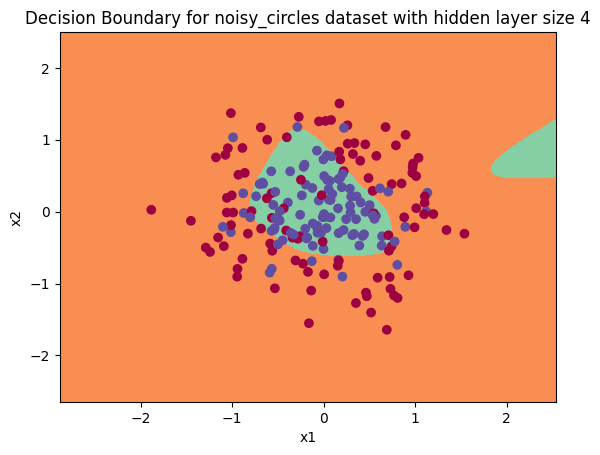

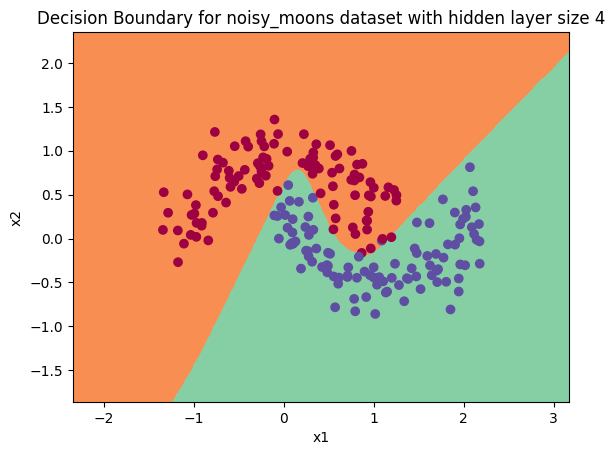

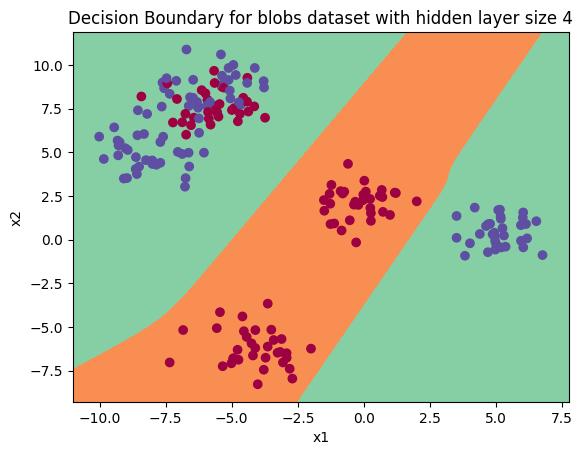

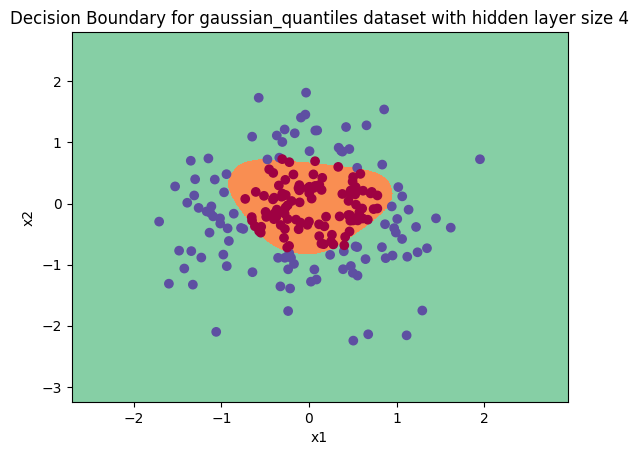

In [23]:
# Import the required libraries
import matplotlib.pyplot as plt

# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# Define a function to train and visualize the model for a given dataset
def train_and_visualize(dataset_name, n_h=4, num_iterations=10000, print_cost=True):
    X, Y = datasets[dataset_name]
    X, Y = X.T, Y.reshape(1, Y.shape[0])

    if dataset_name == "blobs":
        Y = Y % 2

    # Build a model with a n_h-dimensional hidden layer
    parameters = nn_model(X, Y, n_h, num_iterations, print_cost)

    # Plot the decision boundary
    plt.figure()
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    plt.title(f"Decision Boundary for {dataset_name} dataset with hidden layer size {n_h}")

# Loop through the datasets and train/visualize the model
for dataset_name in datasets:
    train_and_visualize(dataset_name)

plt.show()
